# TimesFM Financial Forecasting Demo

Financial forecasting using Google's TimesFM with Bitcoin prices and market covariates.

Target: Bitcoin weekly prices  
Covariates: Ethereum, VIX, S&P 500  
Horizon: 4 weeks ahead


## Setup


In [9]:
import warnings
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import timesfm

from forecast_utils import (
    generate_synthetic_financial_data,
    initialize_timesfm_model,
    generate_prediction_intervals,
    create_professional_forecast_visualization
)

warnings.filterwarnings('ignore')
plt.style.use('default')
np.random.seed(42)


## Generate Data


In [10]:
synthetic_df = generate_synthetic_financial_data(num_weeks=80, start_date='2020-01-01')

print(f"Generated {len(synthetic_df)} weeks of data")
print(f"Date range: {synthetic_df['Date'].min().date()} to {synthetic_df['Date'].max().date()}")
display(synthetic_df.head())

synthetic_df.to_csv('synthetic_financial_data.csv', index=False)


🎲 Generating 80 weeks of synthetic financial data...
   📅 Period: 2020-01-03 to 2021-07-09
   💰 BTC range: $20,224 - $50,247
   💎 ETH range: $1233 - $3,054
   📈 SPX range: 3432 - 4,945
   📊 VIX range: 10.0 - 27.4

📈 Realized Correlations:
   BTC-ETH: 0.985
   BTC-SPX: 0.895
   BTC-VIX: -0.074
Generated 80 weeks of data
Date range: 2020-01-03 to 2021-07-09


,Date,BTC_price,ETH_price,SPX_price,VIX_price,month,quarter,year
0,2020-01-03,20810.744291,1234.930051,3432.432986,10.000000,1,1,2020
1,2020-01-10,20223.623065,1235.083714,3566.040072,20.514992,1,1,2020
2,2020-01-17,22015.177186,1418.518929,3615.629886,18.554879,1,1,2020
3,2020-01-24,24129.011124,1410.224624,3499.167972,18.599221,1,1,2020
4,2020-01-31,21412.581073,1232.819060,3625.847123,21.788577,1,1,2020


## Data Overview


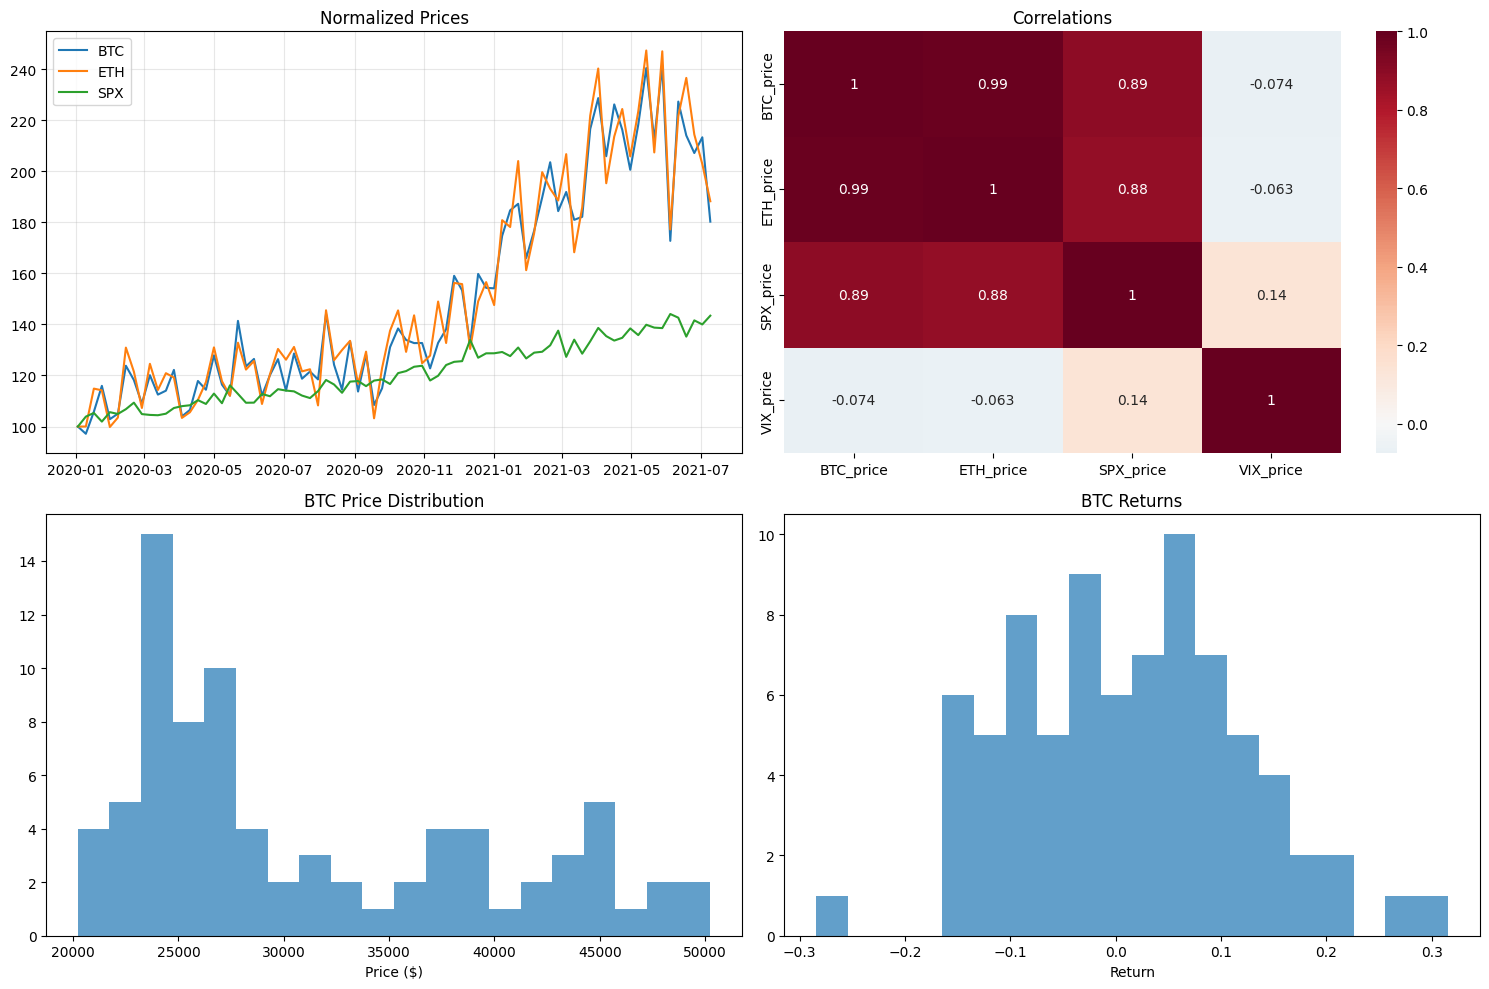

Summary statistics:


,BTC_price,ETH_price,SPX_price,VIX_price
count,80.000000,80.000000,80.000000,80.000000
mean,31209.770206,1871.103729,4159.017946,19.760278
std,8519.272179,517.799319,417.891593,2.584922
min,20223.623065,1232.819060,3432.432986,10.000000
25%,24452.613109,1491.893507,3808.380657,18.242607
50%,27616.635742,1629.586533,4062.458403,19.587251
75%,38022.014599,2302.667454,4502.402754,21.544863
max,50246.995144,3053.770286,4945.467992,27.351913


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price chart
ax1 = axes[0, 0]
price_cols = ['BTC_price', 'ETH_price', 'SPX_price']
for col in price_cols:
    normalized = (synthetic_df[col] / synthetic_df[col].iloc[0]) * 100
    ax1.plot(synthetic_df['Date'], normalized, label=col.replace('_price', ''))
ax1.set_title('Normalized Prices')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Correlation heatmap
ax2 = axes[0, 1]
corr_matrix = synthetic_df[['BTC_price', 'ETH_price', 'SPX_price', 'VIX_price']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax2)
ax2.set_title('Correlations')

# Price distribution
ax3 = axes[1, 0]
ax3.hist(synthetic_df['BTC_price'], bins=20, alpha=0.7)
ax3.set_title('BTC Price Distribution')
ax3.set_xlabel('Price ($)')

# Returns distribution
ax4 = axes[1, 1]
btc_returns = synthetic_df['BTC_price'].pct_change().dropna()
ax4.hist(btc_returns, bins=20, alpha=0.7)
ax4.set_title('BTC Returns')
ax4.set_xlabel('Return')

plt.tight_layout()
plt.savefig('data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("Summary statistics:")
display(synthetic_df[['BTC_price', 'ETH_price', 'SPX_price', 'VIX_price']].describe())


## Initialize Model


In [12]:
timesfm_model = initialize_timesfm_model(backend="cpu")

if timesfm_model is None:
    raise RuntimeError("Failed to initialize TimesFM model")

print("Model initialized successfully")


🤖 Initializing TimesFM model with cpu backend...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

✅ TimesFM model initialized successfully!
   📊 Model: google/timesfm-2.0-500m-pytorch
   🧠 Layers: 50
   💻 Backend: cpu
   📏 Context length: 512 tokens
   🔮 Forecast horizon: 4 weeks

🧪 Testing basic forecasting...
✅ Basic forecast test passed! Output shape: (1, 4)
✅ Covariates functionality available!
Model initialized successfully


## Forecasting


Historical: 2020-11-06 to 2021-06-11
Forecast: 2021-06-18 to 2021-07-09
🔮 Generating prediction intervals with 60 bootstrap samples...
   📊 Computing base forecast...
   ✅ Base forecast computed: 4 periods
   🎲 Generating bootstrap samples...
   ✅ Generated 60 successful forecasts
   📊 Prediction Interval Analysis:
      80% interval width: $11,237 (27.6% of forecast)
      50% interval width: $6,273 (15.4% of forecast)
      Forecast range: $36,362 - $44,560
📊 Creating professional forecast visualization...


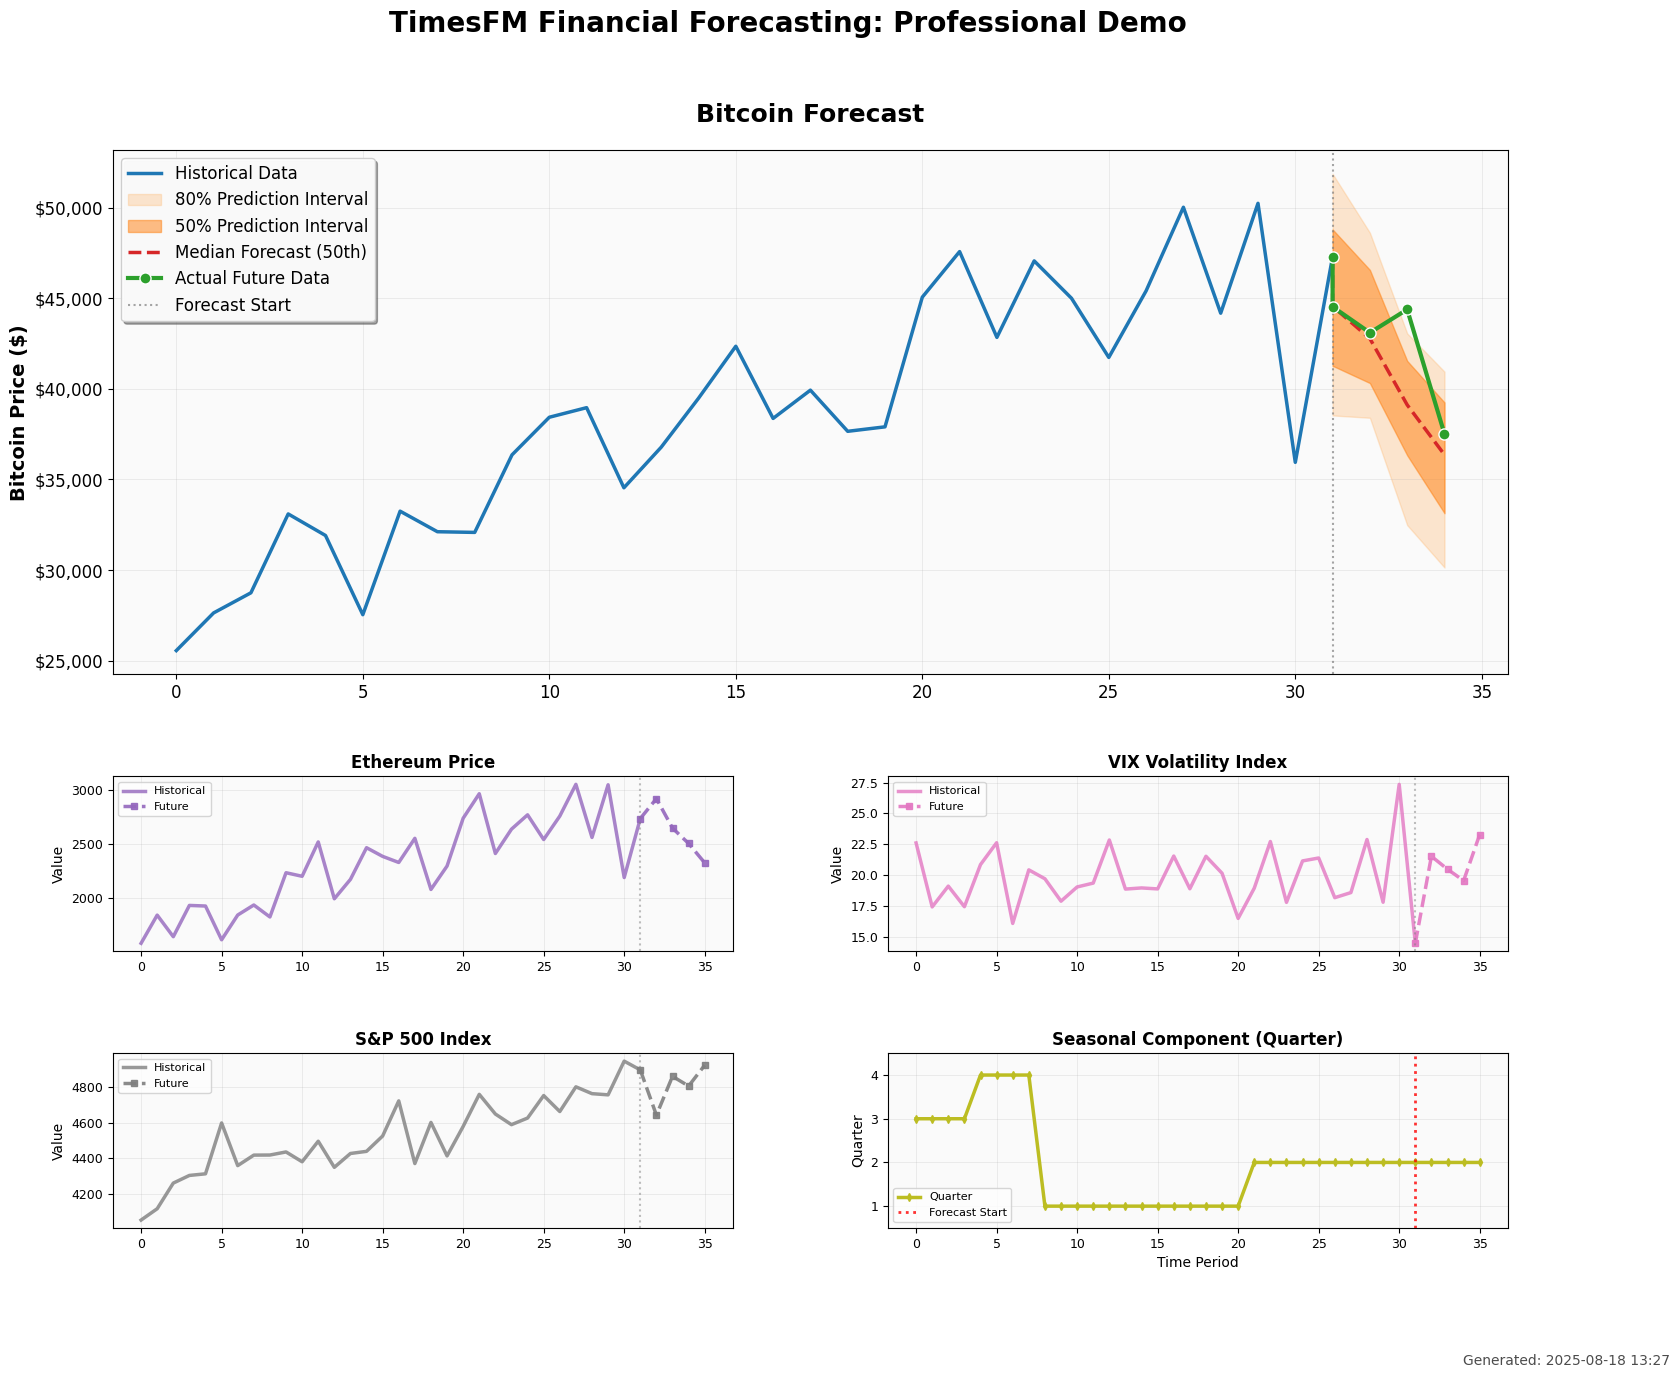

✅ Professional visualization created and saved!

Performance:
MAE: $1,692
RMSE: $2,701
MAPE: 3.9%
Directional Accuracy: 66.7%
80% Coverage: 75.0%
50% Coverage: 75.0%
Results saved to forecast_results.csv


In [13]:
# Data preparation
context_weeks = 32
horizon_weeks = 4
total_needed = context_weeks + horizon_weeks

start_idx = len(synthetic_df) - total_needed
end_context = start_idx + context_weeks
end_horizon = end_context + horizon_weeks

historical_data = synthetic_df.iloc[start_idx:end_context].copy()
future_data = synthetic_df.iloc[end_context:end_horizon].copy()

target_historical = historical_data['BTC_price'].values
target_future = future_data['BTC_price'].values

print(f"Historical: {historical_data['Date'].iloc[0].date()} to {historical_data['Date'].iloc[-1].date()}")
print(f"Forecast: {future_data['Date'].iloc[0].date()} to {future_data['Date'].iloc[-1].date()}")

# Prepare covariates
full_period = synthetic_df.iloc[start_idx:end_horizon]

covariates_data = {
    'eth': [full_period['ETH_price'].tolist()],
    'vix': [full_period['VIX_price'].tolist()],
    'spx': [full_period['SPX_price'].tolist()]
}

categorical_covariates = {
    'month': [full_period['month'].tolist()],
    'quarter': [full_period['quarter'].tolist()]
}

# Generate forecasts with prediction intervals
median_forecast, lower_80, upper_80, lower_50, upper_50 = generate_prediction_intervals(
    model=timesfm_model,
    target_data=target_historical,
    covariates_data=covariates_data,
    categorical_covariates=categorical_covariates,
    num_samples=60
)

# Visualization
covariate_viz_data = {
    'ETH': {
        'historical': historical_data['ETH_price'].values,
        'future': future_data['ETH_price'].values
    },
    'VIX': {
        'historical': historical_data['VIX_price'].values,
        'future': future_data['VIX_price'].values
    },
    'SPX': {
        'historical': historical_data['SPX_price'].values,
        'future': future_data['SPX_price'].values
    }
}

create_professional_forecast_visualization(
    historical_data=target_historical,
    actual_future=target_future,
    median_forecast=median_forecast,
    lower_80=lower_80,
    upper_80=upper_80,
    lower_50=lower_50,
    upper_50=upper_50,
    covariate_data=covariate_viz_data,
    dates_historical=historical_data['Date'],
    dates_future=future_data['Date'],
    title="Bitcoin Forecast"
)

# Performance metrics
mae = np.mean(np.abs(median_forecast - target_future))
rmse = np.sqrt(np.mean((median_forecast - target_future) ** 2))
mape = np.mean(np.abs((target_future - median_forecast) / target_future)) * 100

actual_dirs = np.sign(np.diff(target_future))
pred_dirs = np.sign(np.diff(median_forecast))
dir_accuracy = np.mean(actual_dirs == pred_dirs) * 100

coverage_80 = np.mean((target_future >= lower_80) & (target_future <= upper_80)) * 100
coverage_50 = np.mean((target_future >= lower_50) & (target_future <= upper_50)) * 100

print(f"\nPerformance:")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"MAPE: {mape:.1f}%")
print(f"Directional Accuracy: {dir_accuracy:.1f}%")
print(f"80% Coverage: {coverage_80:.1f}%")
print(f"50% Coverage: {coverage_50:.1f}%")

# Save results
results_df = pd.DataFrame({
    'Date': future_data['Date'],
    'Actual': target_future,
    'Forecast': median_forecast,
    'Error': target_future - median_forecast,
    'Lower_80': lower_80,
    'Upper_80': upper_80,
    'Lower_50': lower_50,
    'Upper_50': upper_50
})

results_df.to_csv('forecast_results.csv', index=False)
print("Results saved to forecast_results.csv")
